# 1Strategy ML Immersion Day
### Building an xgboost model from movie data

In [1]:
import json
import math
import sys

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker as sm
from sagemaker.amazon.amazon_estimator import get_image_uri

import workshop_utils as wu

# prevent warnings from displaying
import warnings
warnings.filterwarnings('ignore')

## Initialize variables

In [2]:
bucket    = '1s-ml'
# !!!!!!!!!!!!!!!!!!
# PUT YOUR NAME HERE
your_name = 'agraves'

model_artifacts_location = f's3://{bucket}/movies/artifacts/{your_name}'

role = sm.get_execution_role()
sm_session = sm.session.Session()

print(f'IAM Role: {role}')

ratings = 'movies/data/title.ratings.tsv'
basics = 'movies/data/title.basics.tsv'

IAM Role: arn:aws:iam::842337631775:role/service-role/AmazonSageMaker-ExecutionRole-20190722T122244


### A note about this data
source: https://datasets.imdbws.com

We will be downloading the data from S3 in order to inspect it and perform any cleanup necessary before we train our model.

In [3]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(ratings, 'ratings.tsv')
s3.Bucket(bucket).download_file(basics, 'basics.tsv')

In [4]:
ratings_csv = pd.read_csv('ratings.tsv', sep='\t')
basics_csv = pd.read_csv('basics.tsv', sep='\t')
movie_data = pd.merge(ratings_csv, basics_csv, how='inner', on='tconst')
print(f'Movie Data Shape: {movie_data.shape}')

movie_data.head(15)

Movie Data Shape: (977590, 11)


,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.6,1539,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,6.1,186,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,6.5,1198,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,6.2,114,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,6.1,1910,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
5,tt0000006,5.2,103,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,5.4,612,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,5.4,1644,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,5.4,81,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,6.9,5488,short,Exiting the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


## Cleanup

There are several unecessary columns in this data as well as observations we aren't concerned about. This is an investigation of movie ratings, so we can eliminate the rows which contain data about television shows. This data also contains records from silent films. We can make a reasonable assumption that silent film appreciation is a bit different than modern film appreciation, so we will drop these observations as well.

In [5]:
# Eliminate TV Shows
movie_data = movie_data[(movie_data.titleType == 'movie') | (movie_data.titleType == 'short') | (movie_data.titleType == 'tvMovie')]
# Shape: (395863, 11)

# Limit to only years with talkies
movie_data = movie_data[movie_data.startYear != '\\N']
movie_data.startYear = movie_data.startYear.astype(int)
movie_data = movie_data[movie_data.startYear > 1927]
# Shape: (383612, 11)

# Remove unnecessary columns
movie_data.drop('originalTitle', axis=1, inplace=True)
movie_data.drop('endYear', axis=1, inplace=True)
movie_data.drop('startYear', axis=1, inplace=True)
movie_data.drop('tconst', axis=1, inplace=True)
movie_data.drop('primaryTitle', axis=1, inplace=True)
movie_data.drop('genres', axis=1, inplace=True)
# I am working to one hot encode the genres column. It requires a custom function.
movie_data.head(15)

,averageRating,numVotes,titleType,isAdult,runtimeMinutes
1274,3.7,19,movie,0,56
3746,6.5,55,movie,0,69
3931,6.2,20,movie,0,102
4042,7.1,1250,movie,0,81
4442,7.2,11,short,0,14
4631,7.1,49,movie,0,74
4659,6.1,261,movie,0,108
4671,7.0,8,movie,0,\N
4710,6.7,14,movie,0,\N
4711,6.2,6,movie,0,72


There are some values in this data that are not NaN. We need to convert them before dropping them.

In [6]:
# Convert \\N to NaN
movie_data = movie_data[movie_data != r'\N']

In [7]:
# Check to see how many NaN values we have now that we've dropped the /N entries
movie_data.isna().sum()

averageRating         0
numVotes              0
titleType             0
isAdult               0
runtimeMinutes    46557
dtype: int64

In [8]:
# Remove any observations with null values
movie_data.dropna(inplace=True)
movie_data.isna().sum()

averageRating     0
numVotes          0
titleType         0
isAdult           0
runtimeMinutes    0
dtype: int64

### Save data for use in the next model

In [9]:
movie_data.to_csv('movie_data.csv', index=False)

## Visualization

It is quite important to spend time visualizing your data in order to see any patterns or relations within it. We won't spend much time here mulling over plots, but I wanted to show at least one. The plot below should show the relationship between the number of votes a movie has its average rating. We can see that as the average rating increases a movie receives more votes.

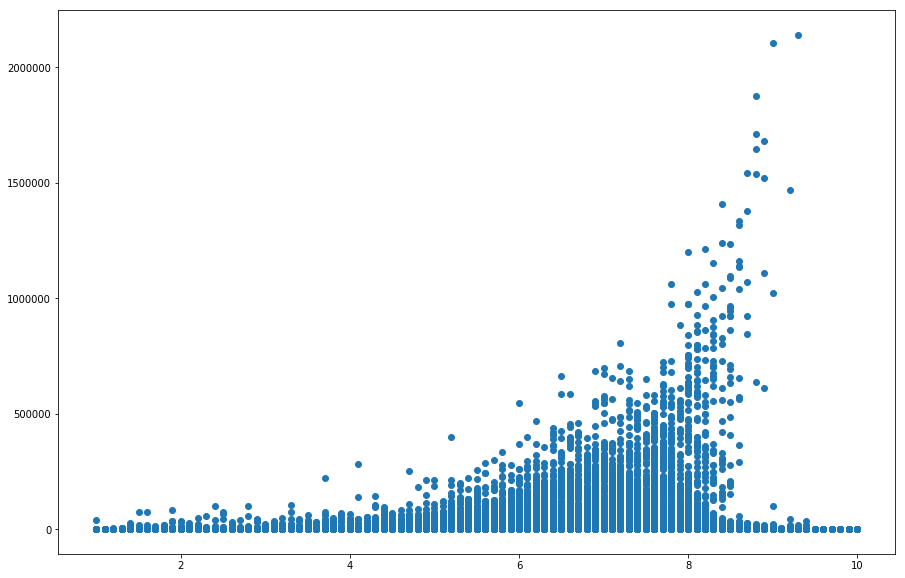

In [13]:
# # Create a figure instance
fig = plt.figure(1, figsize=(15, 10))

# # Create an axes instance
ax = fig.add_subplot(111)

# plt.plot(movie_data.titleType, movie_data.numVotes, 'o')
plt.plot(movie_data.averageRating, movie_data.numVotes, 'o')


## Model Prep

The simplest prediction type to grok is a binary outcome. Our data doesn't have a binary value, but we can create one. We will, of course, lose some granularity in the detail of our ratings system, but a binary value for "likability" may be enough to answer our business problem.

In [ ]:
# Create a binary dependent variable
likable = movie_data.apply(lambda row: wu.label_rating(row), axis=1)
movie_data = pd.concat([likable, movie_data], axis=1)
movie_data.rename(columns={0:'likable'}, inplace=True)
movie_data.drop('averageRating', axis=1, inplace=True)
movie_data.head(15)

We have another problematic column: the titleType column. This field indicates the type of film for each observation. There are only three possibilities movie, short, and tvMovie. We can use the *pandas* built in method *.get_dummies()* to create three dummy columns corresponding to the types. This is called one hot encoding, and it is necessary here because the xgboost algorithm requires its inputs to be numeric, not categorical.

In [ ]:
# One Hot Encode titleType column
dummy_types = pd.get_dummies(movie_data['titleType'])
movie_data = pd.concat([movie_data, dummy_types.reindex(movie_data.index)], axis=1)
movie_data.drop('titleType', axis=1, inplace=True)

movie_data.head(15)

In [ ]:
# Now that we have only numbers in runtimeMinutes, we can convert to int
movie_data['runtimeMinutes'] = movie_data['runtimeMinutes'].astype(int)
movie_data['movie'] = movie_data['movie'].astype(int)
movie_data['short'] = movie_data['short'].astype(int)
movie_data['tvMovie'] = movie_data['tvMovie'].astype(int)
movie_data.dtypes

### A note about splitting data

Our data needs to be divided into three pieces. We need a subset of our observations for training the model on, a subset to evaluate the effectiveness of the model, and a subset to test our hosted endpoint. Typically, data is divided between test and validation at a proportion of 70% training to 30% validation. Here, it will be 70% training, 20% validation, and 10% test.

The split function below is rather unintuitive. The *.sample()* method is randomly sorting the columns so they are not in a particular order. Then the *.split()* method is dividing the dataset at the 70% mark and the 90% mark, resulting in three new datasets.

In [12]:
movie_train, movie_eval, movie_test = np.split(movie_data.sample(frac=1, random_state=1278), [int(0.7 * len(movie_data)), int(0.9 * len(movie_data))])
print(f'Movie Train Shape: {movie_train.shape}')
print(f'Movie Eval Shape: {movie_eval.shape}')
print(f'Movie Test Shape: {movie_test.shape}')

Movie Train Shape: (235938, 5)
Movie Eval Shape: (67411, 5)
Movie Test Shape: (33706, 5)


In [ ]:
movie_train.dtypes

Now that we have our individual data sets, we need to store them in S3 to be retrievable by SageMaker when it creates our training instance.

In [ ]:
movie_train.to_csv('movie_train.csv', header=False, index=False)
train_upload = f'movies/artifacts/{your_name}/movie_train.csv'
s3.Bucket(bucket).Object(train_upload).upload_file('movie_train.csv')

In [ ]:
movie_eval.to_csv('movie_eval.csv', header=False, index=False)
eval_upload = f'movies/artifacts/{your_name}/movie_eval.csv'
s3.Bucket(bucket).Object(eval_upload).upload_file('movie_eval.csv')

## Create ML resources

The designation of the 'xgboost' container below is the indicator that we are using the xgboost algorithm. The SageMaker Python SDK provides an Estimator class for creatng model resources. This is quite similar to TensorFlow except the type of model is designated by the container image we pass into the class. If it were necessary, we could provision multiple training instances to perform the work faster, but in this example a single instance will do.

In [ ]:
container = get_image_uri('us-west-2', 'xgboost', '0.90-1')

xgboost = sm.estimator.Estimator(
    container,
    role,
    base_job_name=f'{your_name}-ml-im',
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=f's3://{bucket}/movies/artifacts/{your_name}/output',
    sagemaker_session=sm_session)

In [10]:
# sc_pos_weight = sum(negative cases) / sum(positive cases)

### A note about hyperparameters

Hyperparameters control the execution of the algorithm being used to train the model. There are many hyperparameters available for the built in xgboost algorithm, but we are only setting six.

**max_depth**: maximum depth of a tree. a higher value can induce overfitting.

**eta**: shrinks the feature weights during each step. this is useful for preventing overfitting because a higher value makes the boosting more conservative (take smaller steps)

**subsample**: sets the amount of data sampled for each tree grown.

**objective**: specifies the learning task and type

**scale_pos_weight**: controls the balance of weighting between positive and negative weights

**num_round**: number of training rounds

For more details on the xgboost hyperparameters, check: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

In [ ]:
xgboost.set_hyperparameters(
    max_depth=3,
    eta=0.1,
    subsample=0.5,
    objective='binary:logistic',
    scale_pos_weight=2.0,
    num_round=100)

The *.fit()* method will map data from our locations to the specific channels recognized by the xgboost container. The SageMaker service will then spin up a training instance based on the training attributes we specified when the Estimator was created. This is a syncronous call, so you should see training validation return here in the notebook.

In [ ]:
train_data = sm.s3_input(s3_data=f's3://{bucket}/{train_upload}', content_type='csv')
eval_data = sm.s3_input(s3_data=f's3://{bucket}/{eval_upload}', content_type='csv')

xgboost.fit({'train': train_data, 'validation': eval_data})

## Deploy model

Now that we have a successfully trained model in SageMaker (you can go verify this in the AWS console), we need to "deploy" this model. The *.deploy()* method will instruct SageMaker to create a hosting instance of our desired size to present our model behind an endpoint.

In [ ]:
xgboost_predict = xgboost.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large')
xgboost_predict.content_type = 'text/csv'
xgboost_predict.deserializer = None

In [ ]:
# We need to drop the label column in order to retreive inferences for this data
movie_test.drop('likable', axis=1, inplace=True)
movie_test.to_csv('movie_test.csv', header=False, index=False)
movie_test.head(15)

The return value of the *.deploy()* method is the SageMaker endpoint resource. We can use this endpoint resource to retreive inferences of our test data.

In [ ]:
with open('movie_test.csv', 'r') as file:
    payload = file.read().strip()

test_data = [line for line in payload.split('\n')]
preds = wu.do_predict(test_data, xgboost_predict)
print(preds)

## Delete endpoint when done

In [ ]:
sm_session.delete_endpoint(xgboost_predict.endpoint)